### hypotheses
1. rain&wind reduces, while humidity increases PM2.5
2. less PM2.5 in polar zones & tropical-zones, more in temperate & continental Zones
    - polar: no humans, stagnant weather patterns trap PM2.5
    - tropical-zones (rain washes it out)
    - temperate/contintental - more humans & weather patterns conducive to trapping PM2.5
3. PM2.5 increase in urban areas
    - urban = high NO2
    - weekends = less PM2.5, because people relax
4. Higher Concentration of gases (CO,NO2,AER_AI?,) correlate positively with PM2.5 


In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, PowerTransformer, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

RSEED=826

In [2]:
# import data and immediate train test split
df = pd.read_csv('data/data.csv')

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

df_train, df_test = train_test_split(df, random_state=RSEED)


In [57]:
df_train.columns

Index(['Place_ID X Date', 'Date', 'Place_ID', 'target', 'target_min',
       'target_max', 'target_variance', 'target_count',
       'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'L3_NO2_NO2_column_number_density', 'L3_NO2_absorbing_aerosol_index',
       'L3_NO2_cloud_fraction', 'L3_NO2_sensor_altitude',
       'L3_O3_O3_column_number_density', 'L3_O3_O3_effective_temperature',
       'L3_CO_CO_column_number_density', 'L3_CO_cloud_height',
       'L3_HCHO_HCHO_slant_column_number_density',
       'L3_CLOUD_cloud_base_height', 'L3_CLOUD_cloud_optical_depth',
       'L3_CLOUD_surface_albedo', 'L3_AER_AI_sensor_altitude',
       'L3_SO2_SO2_column_number_density', 'L3_SO2_absorbing_aerosol_index'],
      dtype='object')

In [3]:
df_train.head()

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
3121,2JZW8ZM X 2020-03-09,2020-03-09,2JZW8ZM,27.0,1.0,115.0,1611.93,253,13.070044,86.133336,...,40.859311,-7.812209,57.584962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14141,EVXOAKQ X 2020-03-25,2020-03-25,EVXOAKQ,21.0,5.0,157.0,4908.25,56,26.500000,75.900002,...,57.229369,-121.763823,33.091599,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18250,J3HFUPO X 2020-03-24,2020-03-24,J3HFUPO,114.0,63.0,161.0,4848.00,333,20.200001,97.099998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1466,1LC5FAK X 2020-01-03,2020-01-03,1LC5FAK,25.0,5.0,55.0,1144.47,47,14.400000,84.150002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13997,EVB4HVG X 2020-02-04,2020-02-04,EVB4HVG,55.0,9.0,682.0,34813.40,445,26.342857,63.071432,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# drop columns with sensor angles as they are not useful for prediction
# as well as 'amf' columns as they hold same information as columns with almost identical name just in different format
for col in df_train.columns:
    if 'angle' in col or 'amf' in col[-3:]:
        df_train.drop([col], axis=1, inplace=True)
        df_test.drop([col], axis=1, inplace=True)

# drop CH4 columns as they include too many nan values
# drop NO2_tropopause_pressure because its highly irregular and probably a weak predictor
drop_cols = ['L3_CH4_CH4_column_volume_mixing_ratio_dry_air', 'L3_CH4_aerosol_height', 'L3_CH4_aerosol_optical_depth', "L3_NO2_tropopause_pressure"]
df_train.drop(drop_cols, axis=1, inplace=True)
df_test.drop(drop_cols, axis=1, inplace=True)

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22917 entries, 3121 to 29745
Data columns (total 44 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Place_ID X Date                                  22917 non-null  object        
 1   Date                                             22917 non-null  datetime64[ns]
 2   Place_ID                                         22917 non-null  object        
 3   target                                           22917 non-null  float64       
 4   target_min                                       22917 non-null  float64       
 5   target_max                                       22917 non-null  float64       
 6   target_variance                                  22917 non-null  float64       
 7   target_count                                     22917 non-null  int64         
 8   precipitable_water_entire_atmosphere  

In [5]:
# drop rows where target value is above 500 as this is already a very extreme value for pm2.5 concentration
df_train = df_train[df_train['target'] < 500]
df_test = df_test[df_test['target'] < 500]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22912 entries, 3121 to 29745
Data columns (total 44 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Place_ID X Date                                  22912 non-null  object        
 1   Date                                             22912 non-null  datetime64[ns]
 2   Place_ID                                         22912 non-null  object        
 3   target                                           22912 non-null  float64       
 4   target_min                                       22912 non-null  float64       
 5   target_max                                       22912 non-null  float64       
 6   target_variance                                  22912 non-null  float64       
 7   target_count                                     22912 non-null  int64         
 8   precipitable_water_entire_atmosphere  

In [ ]:
# visualize correlations between columns for each gas separately
gases = ['NO2', 'O3', 'CO', 'HCHO', 'CLOUD', 'AER', 'SO2']

fig, axes = plt.subplots(len(gases)+1, 1, figsize=(16, 100))
axes = axes.flatten()

for ax, gas in zip(axes, gases):
    col_keeps = [col for col in df_train.columns if gas in col]
    corr_gas = df_train[col_keeps + ['target']]
    sns.heatmap(corr_gas.corr(), annot=True, ax=ax, vmin=-1, vmax=1)

# ... and cluster the cols below as weather
weather = ['humidity', 'wind', 'water', 'temperature']

col_keeps = [col for col in df_train.columns for w in weather if w in col]
corr_weather = df_train[col_keeps + ['target']]
sns.heatmap(corr_weather.corr(), annot=True, ax=axes[-1], vmin=-1, vmax=1)

plt.tight_layout(pad = 3)

In [7]:
# drop one of two columns which correlate strongly (>0.7) to prevent multicollinearity
use = ['target'] + list(df_train.columns[8:])
corr_df = df_train[use].corr().abs()

upper_tri = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(bool))

threshold = 0.7
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
print(f'Columns to drop [{len(to_drop)}]: {to_drop}\n')

df_train.drop(to_drop, axis=1, inplace=True)
df_test.drop(to_drop, axis=1, inplace=True)
df_train.info()

Columns to drop [17]: ['specific_humidity_2m_above_ground', 'temperature_2m_above_ground', 'L3_NO2_NO2_slant_column_number_density', 'L3_NO2_stratospheric_NO2_column_number_density', 'L3_NO2_tropospheric_NO2_column_number_density', 'L3_O3_cloud_fraction', 'L3_CO_H2O_column_number_density', 'L3_CO_sensor_altitude', 'L3_HCHO_cloud_fraction', 'L3_HCHO_tropospheric_HCHO_column_number_density', 'L3_CLOUD_cloud_base_pressure', 'L3_CLOUD_cloud_fraction', 'L3_CLOUD_cloud_top_height', 'L3_CLOUD_cloud_top_pressure', 'L3_AER_AI_absorbing_aerosol_index', 'L3_SO2_SO2_slant_column_number_density', 'L3_SO2_cloud_fraction']

<class 'pandas.core.frame.DataFrame'>
Index: 22912 entries, 3121 to 29745
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Place_ID X Date                           22912 non-null  object        
 1   Date                                 

In [8]:
# check for duplicates
df_train.duplicated().value_counts()

False    22912
Name: count, dtype: int64

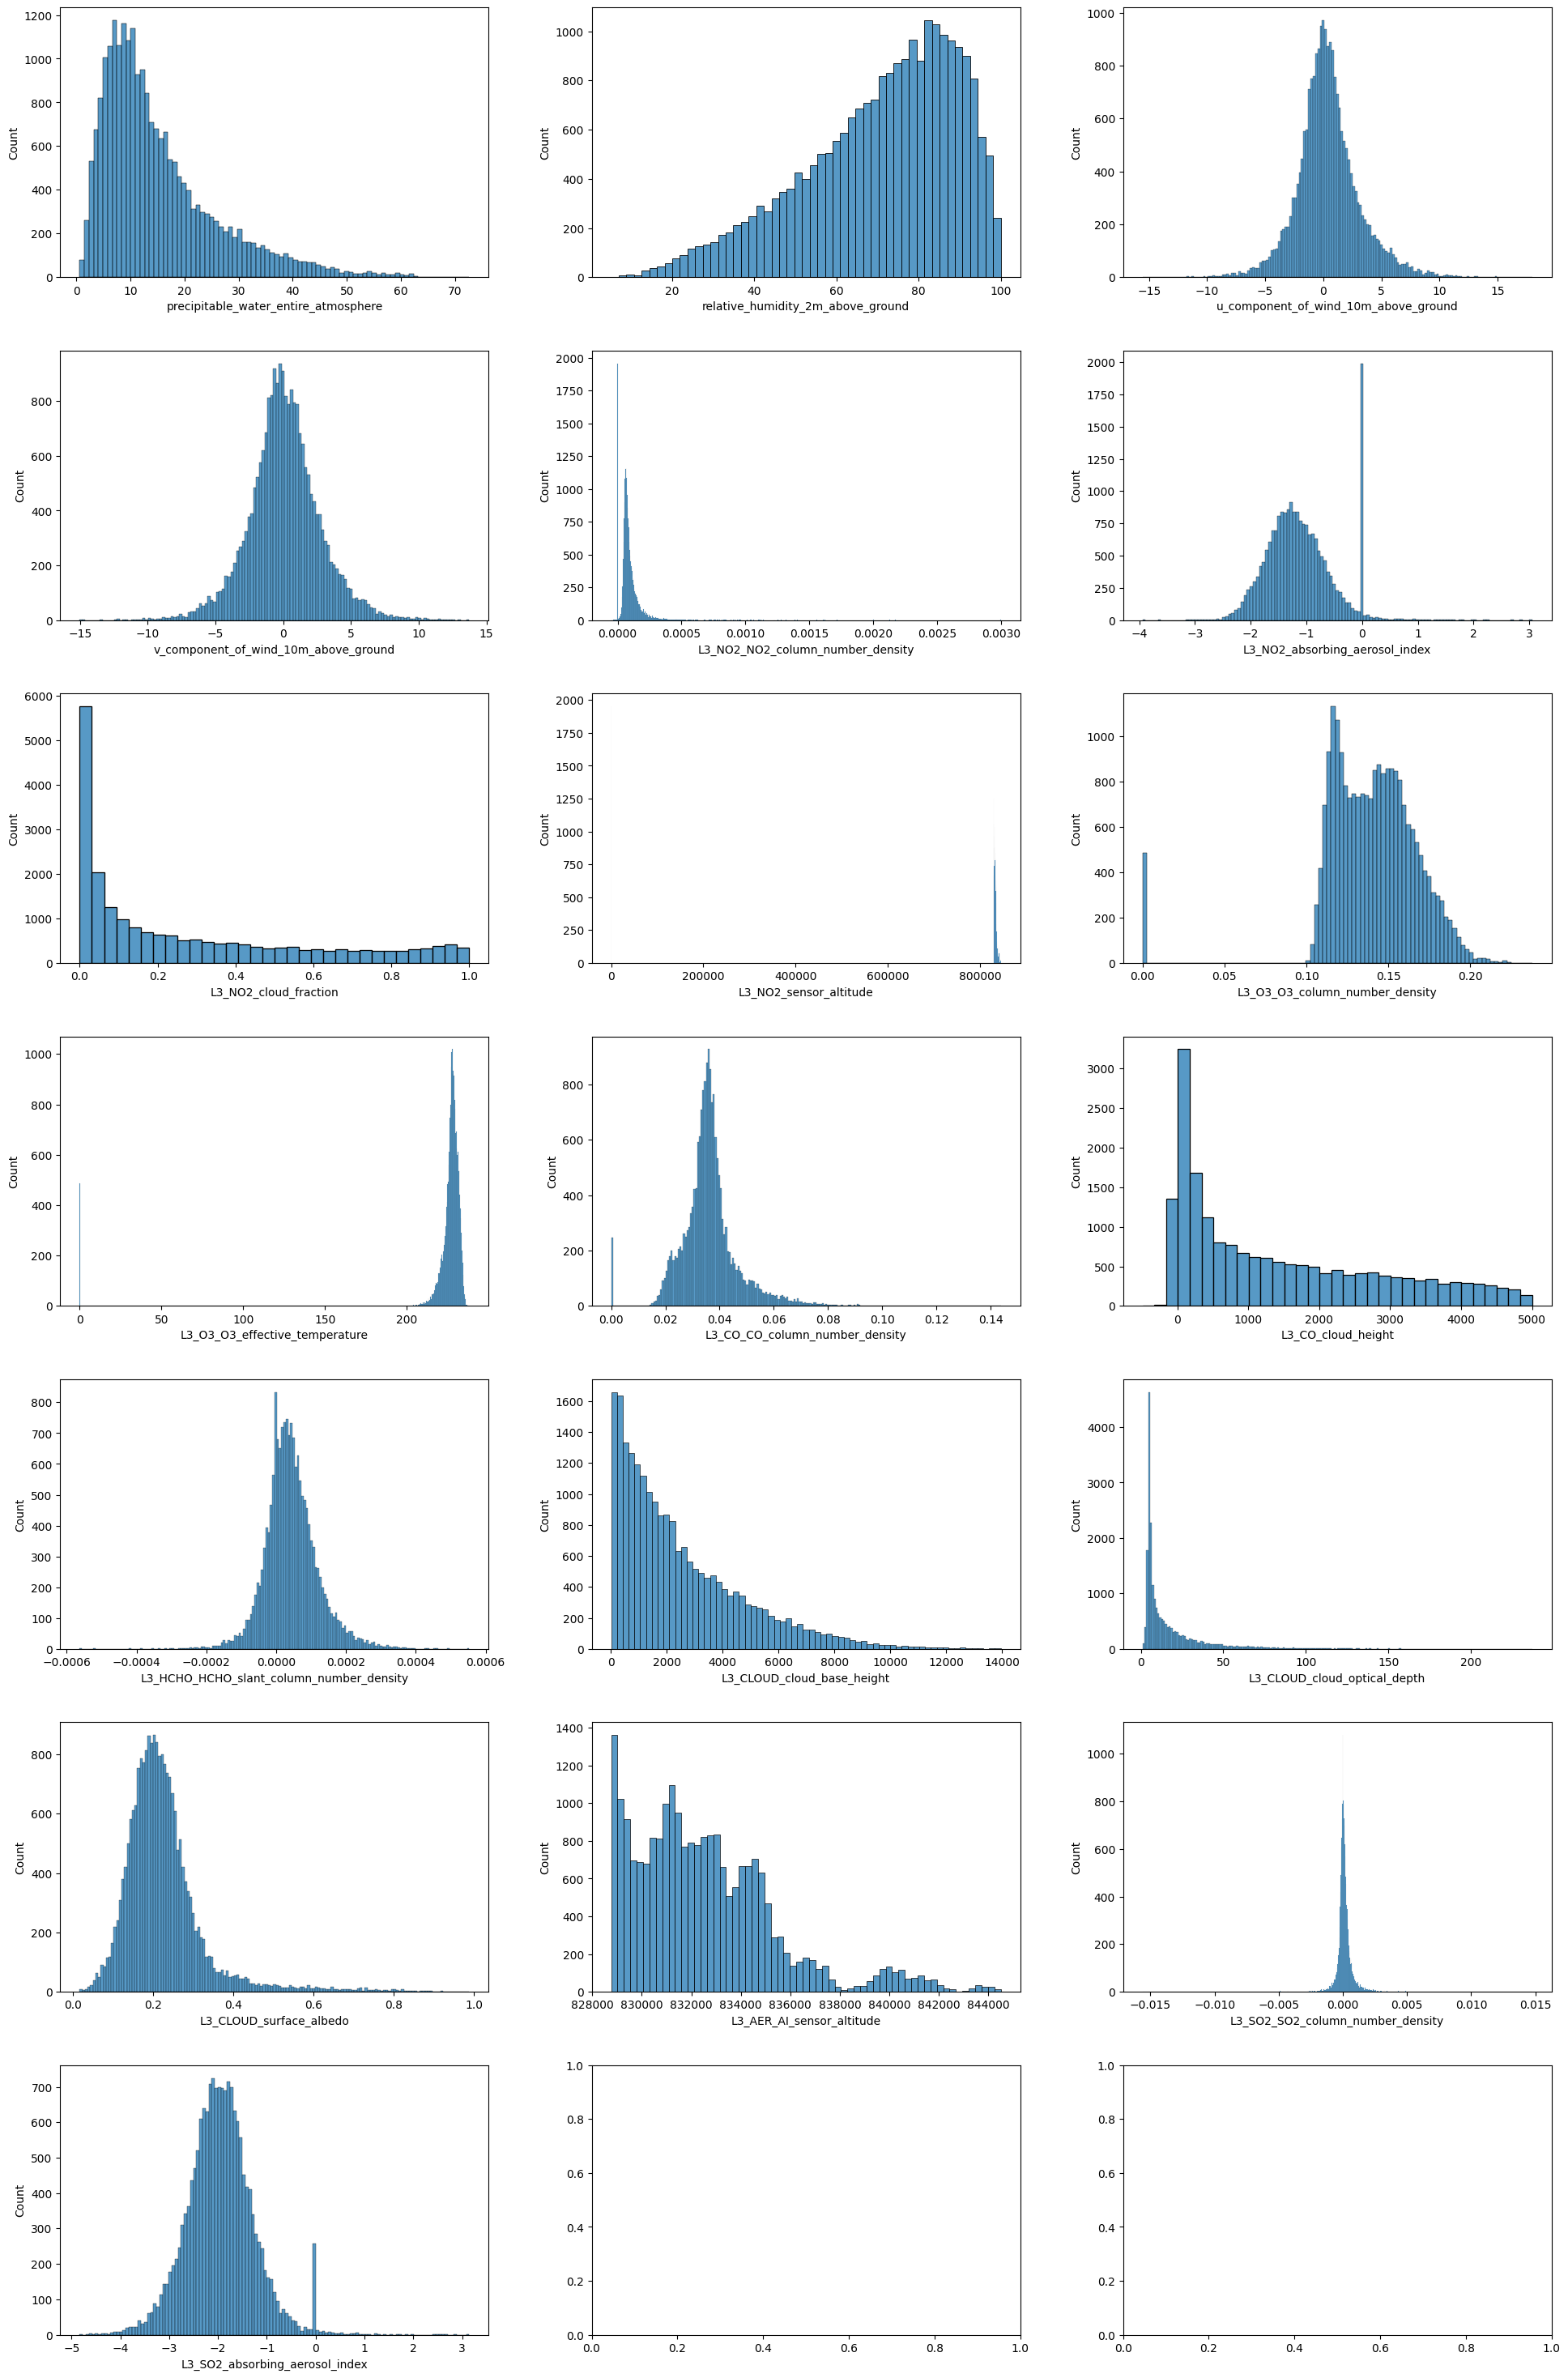

In [9]:
# visualize histograms of features to spot outliers or irregular distributions
fix, axes = plt.subplots(7, 3, figsize=(20, 30))
axes = axes.flatten()

for ax, col in zip(axes, df_train.columns[8:]):
    sns.histplot(df_train, x=col, ax=ax)

plt.tight_layout(pad=3)

In [10]:
# print descriptive metrics of features to spot outliers
for col in ['target'] + list(df_train.columns[8:]):
    print(f'''{col}
min, mean, max:           {df_train[col].min().round(3)}   {df_train[col].mean().round(3)}   {df_train[col].max().round(3)}
quantiles (25, 50, 75):   {df_train[col].quantile(0.25).round(3)}   {df_train[col].quantile(0.50).round(3)}   {df_train[col].quantile(0.75).round(3)}\n''')

target
min, mean, max:           1.0   61.231   470.0
quantiles (25, 50, 75):   25.0   50.0   80.0

precipitable_water_entire_atmosphere
min, mean, max:           0.664   15.299   72.6
quantiles (25, 50, 75):   7.611   12.2   19.9

relative_humidity_2m_above_ground
min, mean, max:           5.129   70.621   100.0
quantiles (25, 50, 75):   58.815   74.213   85.426

u_component_of_wind_10m_above_ground
min, mean, max:           -15.56   0.409   17.955
quantiles (25, 50, 75):   -1.107   0.219   1.745

v_component_of_wind_10m_above_ground
min, mean, max:           -15.024   0.091   13.728
quantiles (25, 50, 75):   -1.417   0.007   1.571

L3_NO2_NO2_column_number_density
min, mean, max:           -0.0   0.0   0.003
quantiles (25, 50, 75):   0.0   0.0   0.0

L3_NO2_absorbing_aerosol_index
min, mean, max:           -3.942   -1.095   3.051
quantiles (25, 50, 75):   -1.514   -1.171   -0.745

L3_NO2_cloud_fraction
min, mean, max:           0.0   0.278   1.0
quantiles (25, 50, 75):   0.026   0.14

# Baseline Model

<Axes: xlabel='L3_CO_CO_column_number_density', ylabel='target'>

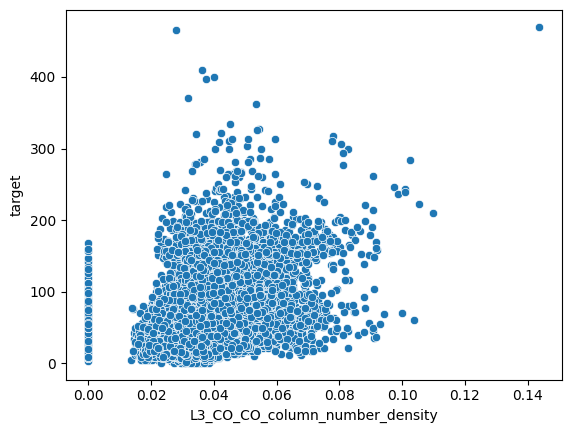

In [11]:
# scatterplot of feature with strongest correlation to target
sns.scatterplot(df_train, x='L3_CO_CO_column_number_density', y='target')

In [68]:
def print_eval_metrics(y_test,y_pred, model_name):
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name:25s} Results")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.2f}")

    return {'model': model_name, 'rmse': rmse, 'r2': r2}

In [69]:
# baseline model based on features associated with air pollution
def baseline_model(df, target_col, feature_cols=None, random_state=RSEED):
    if feature_cols == None:
        feature_cols = df.select_dtypes(include='number').columns.drop(target_col)

    X = df[feature_cols]
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state) #, test_size=0.2

    # fill nan with median of train data
    X_train = X_train.fillna(X_train.median())
    X_test = X_test.fillna(X_train.median())

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # evaluation
    print_eval_metrics(y_test,y_pred,"Linear Regression")

    return model, y_pred

print('-> based on features associated with air pollution')
cols = ["precipitable_water_entire_atmosphere", "relative_humidity_2m_above_ground", "u_component_of_wind_10m_above_ground", "v_component_of_wind_10m_above_ground"] # add clouds?
model, preds = baseline_model(df, target_col="target", feature_cols=cols)

print('\n-> based on feature with strongest correlation to target')
cols = ['L3_CO_CO_column_number_density']
model, preds = baseline_model(df, target_col='target', feature_cols=cols)

-> based on features associated with air pollution
Linear Regression         Results
RMSE: 44.77
R²:   0.04

-> based on feature with strongest correlation to target
Linear Regression         Results
RMSE: 42.85
R²:   0.12


In [14]:
# create list with all features that have weird bar at 0
peak_cols = [
    'L3_NO2_NO2_column_number_density',
    'L3_NO2_absorbing_aerosol_index',
    'L3_NO2_sensor_altitude',
    'L3_O3_O3_column_number_density',
    'L3_O3_O3_effective_temperature',
    'L3_CO_CO_column_number_density',
    "L3_SO2_absorbing_aerosol_index"
    ]

# replace 0s with nan
df_train[peak_cols] = df_train[peak_cols].replace(0, np.nan)
df_test[peak_cols] = df_test[peak_cols].replace(0, np.nan)


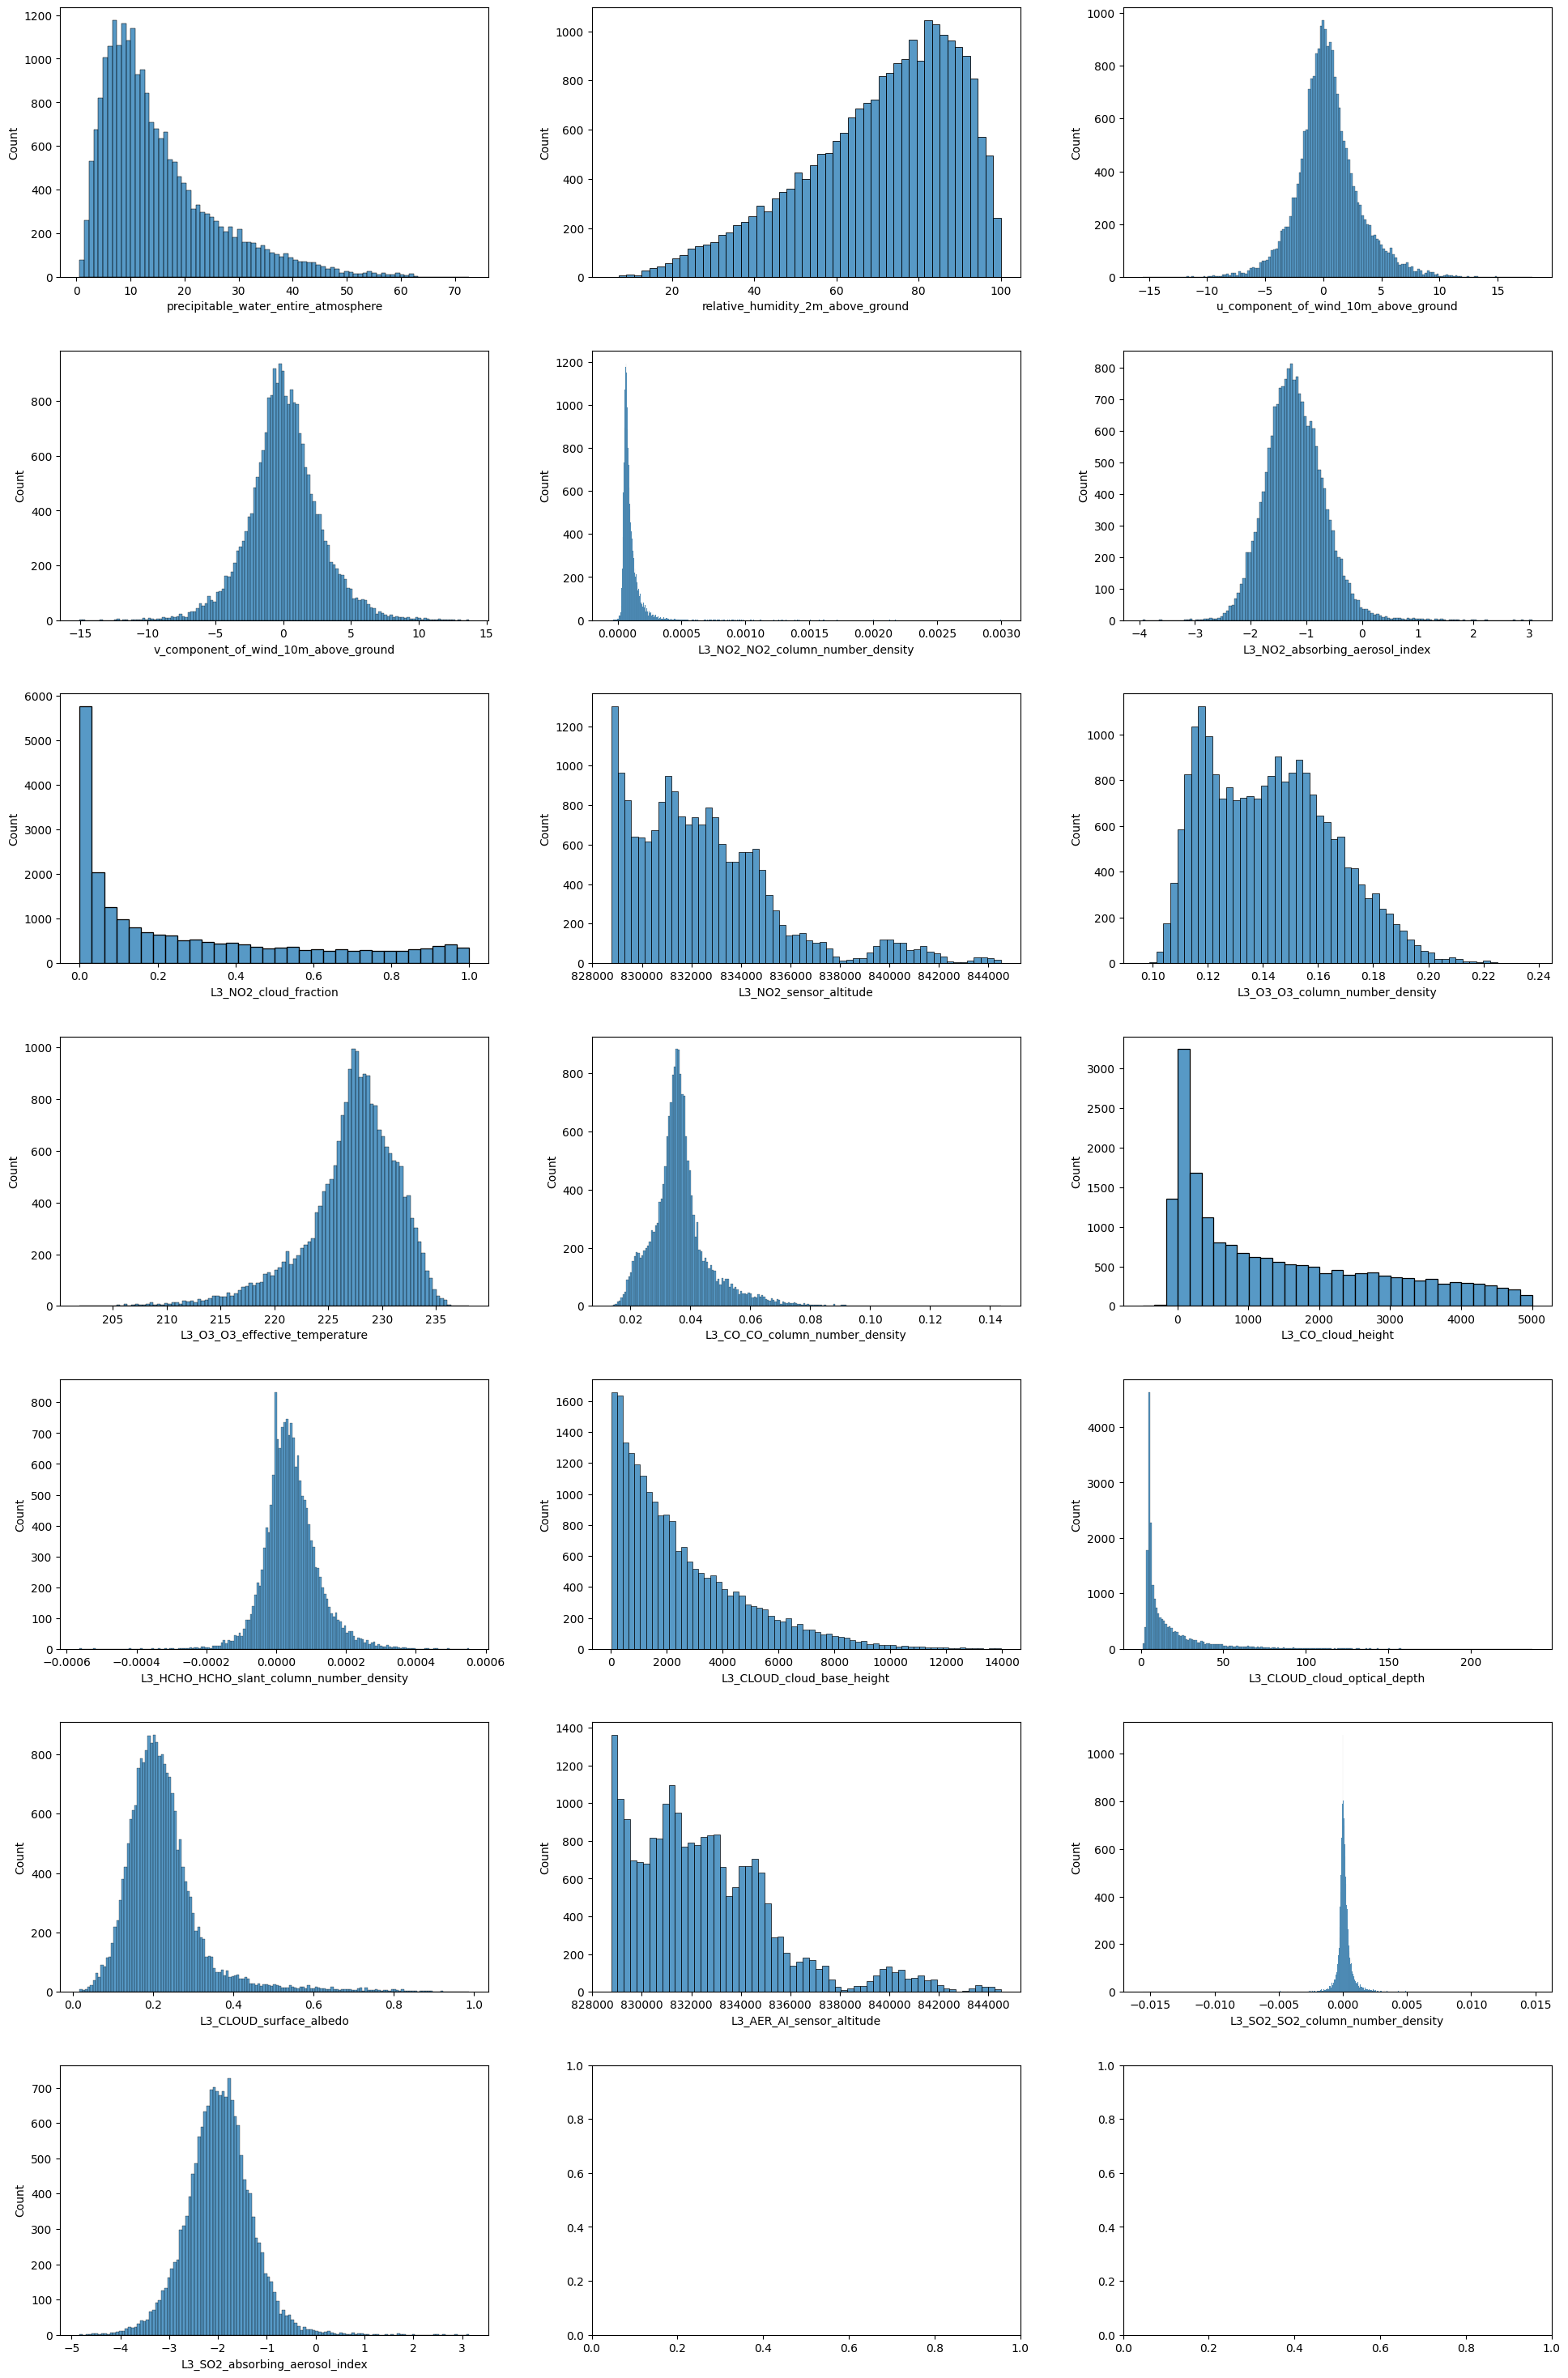

In [15]:
# visualize again to check skew after remove 0
fix, axes = plt.subplots(7, 3, figsize=(20, 30))
axes = axes.flatten()

for ax, col in zip(axes, df_train.columns[8:]):
    sns.histplot(df_train, x=col, ax=ax)

plt.tight_layout(pad=3)

# Pipeline

In [27]:
def clip_outliers(X, lower=0.01, upper=0.99):
    X_ = X.copy()
    q_low = X_.quantile(lower)
    q_high = X_.quantile(upper)
    return X_.clip(q_low, q_high, axis=1)

In [16]:
# define train and test data and exclude location columns, as well as descriptive metrics of target
cols_places = ['Place_ID X Date', 'Place_ID']
cols_target = ['target', 'target_min', 'target_max', 'target_variance', 'target_count']

X_train = df_train.drop(cols_places + cols_target, axis=1)
X_test = df_test.drop(cols_places + cols_target, axis=1)
y_train = df_train['target']
y_test = df_test['target']

In [17]:
# select datetime cols
dt_cols = ['Date']

# select all numerical cols
num_cols = X_train.select_dtypes('number').columns.tolist()

# identify skewed cols
skew_thresh = 0.5
skew_cols2 = X_train[num_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
skew_cols = skew_cols2[abs(skew_cols2) > skew_thresh].index.tolist()

# only select numerical cols which arent skewed
num_cols = list(set(num_cols) - set(skew_cols))


print(f"{len(dt_cols)}      dt cols: {dt_cols}...{type(dt_cols)}")
print(f"{len(skew_cols)} skewed cols: {skew_cols}")
print(f"{len(num_cols)}     num cols:",num_cols)


1      dt cols: ['Date']...<class 'list'>
13 skewed cols: ['L3_NO2_NO2_column_number_density', 'L3_CLOUD_cloud_optical_depth', 'L3_CLOUD_surface_albedo', 'L3_CO_CO_column_number_density', 'precipitable_water_entire_atmosphere', 'L3_CLOUD_cloud_base_height', 'L3_NO2_sensor_altitude', 'L3_AER_AI_sensor_altitude', 'L3_NO2_cloud_fraction', 'L3_CO_cloud_height', 'L3_NO2_absorbing_aerosol_index', 'relative_humidity_2m_above_ground', 'L3_O3_O3_effective_temperature']
6     num cols: ['u_component_of_wind_10m_above_ground', 'v_component_of_wind_10m_above_ground', 'L3_SO2_SO2_column_number_density', 'L3_HCHO_HCHO_slant_column_number_density', 'L3_O3_O3_column_number_density', 'L3_SO2_absorbing_aerosol_index']


### compare models
- LinearRegression() - baseline
- Ridge() - baseline, handles collinearity
- Lasso() - find important features
- ElasticNet() - ridge+lasso: when correl features + find important feature
- RandomForestRegressor() - 
- GradientBoostingRegressor() - better accuracy than randomforest
- XGBoost() - fast, powerful
- LightGBM


In [70]:
# custom transformer - aka preprocessor encoder class for datetime
# ------------------------------------------
# split datetime into its components and add as feature
# capture cyclic nature of dayofweek with sin/cos
#   > important for LinRegression, NN
#   > not important (but not harmful either) for trees
class CyclicDatetimeEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, datetime_cols):
        self.datetime_cols = datetime_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        for col in self.datetime_cols:
            dt = X_[col]
            # simple calendar features
            X_[f"{col}_month"] = dt.dt.month
            X_[f"{col}_day"] = dt.dt.day
            X_[f"{col}_dayofweek"] = dt.dt.dayofweek
            X_[f"{col}_is_weekend"] = dt.dt.dayofweek.isin([5,6]).astype(int)

            # cyclic encoding for dayofweek
            X_[f"{col}_dow_sin"] = np.sin(2 * np.pi * dt.dt.dayofweek / 7)
            X_[f"{col}_dow_cos"] = np.cos(2 * np.pi * dt.dt.dayofweek / 7)

            X_.drop(columns=[col], inplace=True)


    # TransformerMixin:
    # - auto generate fit_transform
    # - to work seamless with pipelines
    # BaseEstimator:
    # - provides some standard methods: .get_params(), .set_params(), ...
    # - for Hyperparam tuning (eg GridSearchCV)
        return X_

In [71]:
# only run datetime preprocess for testing/bugfix
encoder = CyclicDatetimeEncoder(dt_cols)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded  = encoder.transform(X_test)

In [73]:
prep_linreg = ColumnTransformer([
    ('skewed', Pipeline([
        # ('clip', FunctionTransformer(clip_outliers)),
        ('imputer', KNNImputer(n_neighbors=5)),
        ('power', PowerTransformer(method='yeo-johnson')),
        ('scaler', RobustScaler())
    ]), skew_cols),

    ('normal', Pipeline([
        # ('clip', FunctionTransformer(clip_outliers)),
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', RobustScaler())
    ]), num_cols),

    ('datetime', CyclicDatetimeEncoder(dt_cols), dt_cols),
])

prep_tree = ColumnTransformer([
    ('num', KNNImputer(n_neighbors=5), num_cols + skew_cols),
    ('datetime', CyclicDatetimeEncoder(dt_cols), dt_cols),
])

### pipelines using linreg preprocessor
linreg = Pipeline([
    ('preprocessor', prep_linreg),
    ('model', LinearRegression())
])

elastic = Pipeline([
    ('preprocessor', prep_linreg),
    ('model', ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=10000, random_state=RSEED))
])

ridge = Pipeline([
    ('preprocessor', prep_linreg),
    ('model', Ridge(alpha=1.0, random_state=RSEED))
])

lasso = Pipeline([
    ('preprocessor', prep_linreg),
    ('model', Lasso(alpha=1.0, max_iter=10000, random_state=RSEED))
])


### pipelines using tree preprocessor
tree_gbr = Pipeline([
    ('preprocessor', prep_tree),
    ('model', GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,     # Shrinkage (lower = more conservative)
            max_depth=3,           # Shallow trees work best (3-5)
            min_samples_split=5,
            min_samples_leaf=2,
            subsample=0.8,         # Row sampling (0.5-1.0)
            random_state=RSEED
        ))
])

tree_xgb = Pipeline([
    ('preprocessor', prep_tree),
    ('model', XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            min_child_weight=1,    # Min sum of weights in child
            subsample=0.8,         # Row sampling
            colsample_bytree=0.8,  # Column sampling
            random_state=RSEED,
            n_jobs=-1
    ))
])

tree_rf = Pipeline([
    ('preprocessor', prep_tree),
    ('model', RandomForestRegressor(
    n_estimators=120,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt', #log2
    random_state=RSEED,
    n_jobs=-1))
])




### run all pipelines
models = [linreg,ridge,elastic,lasso,tree_rf,tree_gbr,tree_xgb]
results = []
for i, model in enumerate(models):
    modelname = model.named_steps['model'].__class__.__name__
    print(f"\nrunning pipeline #{i+1}/{len(models)} for {modelname}")

    model.fit(X_train, y_train)    # applies all steps in pipeline to train-data
    y_pred = model.predict(X_test) # apply same to test-data

    # evaluation
    res = print_eval_metrics(y_test,y_pred,modelname)
    results.append(res)



running pipeline #1/7 for LinearRegression
LinearRegression          Results
RMSE: 37.38
R²:   0.33

running pipeline #2/7 for Ridge
Ridge                     Results
RMSE: 37.38
R²:   0.33

running pipeline #3/7 for ElasticNet
ElasticNet                Results
RMSE: 38.54
R²:   0.28

running pipeline #4/7 for Lasso
Lasso                     Results
RMSE: 37.70
R²:   0.32

running pipeline #5/7 for RandomForestRegressor
RandomForestRegressor     Results
RMSE: 29.95
R²:   0.57

running pipeline #6/7 for GradientBoostingRegressor
GradientBoostingRegressor Results
RMSE: 33.39
R²:   0.46

running pipeline #7/7 for XGBRegressor
XGBRegressor              Results
RMSE: 33.26
R²:   0.47


In [ ]:
# Analyze results
results_df = pd.DataFrame(results)
# print(results_df.sort_values('r2', ascending=False))
print("=== RESULTS SUMMARY SORTED BY RSME ===")
print(results_df.sort_values('rmse'))


=== RESULTS SUMMARY SORTED BY RSME ===
                       model       rmse        r2
4      RandomForestRegressor  30.435188  0.554062
6               XGBRegressor  33.387024  0.463366
5  GradientBoostingRegressor  33.535533  0.458581
1                      Ridge  37.610593  0.319006
0           LinearRegression  37.610603  0.319006
3                      Lasso  38.014318  0.304307
2                 ElasticNet  38.865876  0.272790


=== RESULTS SUMMARY SORTED BY RSME ===
                       model       rmse        r2
4      RandomForestRegressor  30.435188  0.554062
6               XGBRegressor  33.387024  0.463366
5  GradientBoostingRegressor  33.535533  0.458581
1                      Ridge  37.610593  0.319006
0           LinearRegression  37.610603  0.319006
3                      Lasso  38.014318  0.304307
2                 ElasticNet  38.865876  0.272790


### with clip (linreg only)
```
LinearRegression Results << clip 2% all
RMSE: 37.444
R²:   0.325

LinearRegression Results << clip 1% all
RMSE: 38.036
R²:   0.304

LinearRegression Results << without clip
RMSE: 37.382
R²:   0.327
```


Since RandomForestRegressor won, lets tune its hyperparams!
Too speed things up, lets
- run the tree-preprocessing steps individually 
- then subsample data

In [60]:
# preprocess data outside of pipeline
X_train_prep = prep_tree.fit_transform(X_train)
X_test_prep  = prep_tree.transform(X_test)

# subsample to save time during GridSeachCV
X_train_sample = X_train.sample(frac=0.3, random_state=RSEED)
y_train_sample = y_train.loc[X_train_sample.index]

# preprocess sampled train data
X_train_sample_prep = prep_tree.fit_transform(X_train_sample)

In [61]:
def param_range(center, step_size, n_steps_each_side=2, min_val=1):
    start = max(center - n_steps_each_side * step_size, min_val)
    end = center + n_steps_each_side * step_size
    return list(range(start, end + step_size, step_size))

In [ ]:
# RandomForestRegressor hyperparameter tuning with Randomized- & Grid-SearchC
param_grid_randCV = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [1, 5, 10, 15, 20],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [3, 5, 10, 15, 20],
    'max_features': ['sqrt', 'log2']
}

randCV = RandomizedSearchCV(
    RandomForestRegressor(random_state=RSEED),
    param_grid_randCV,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RSEED)

randCV.fit(X_train_prep, y_train)
best_params = randCV.best_params_
print('Best params RandomSearchCV:', best_params)


param_grid_gridCV = {
    'n_estimators': param_range(best_params['n_estimators'], 20),
    'max_depth': param_range(best_params['max_depth'], 5),
    'min_samples_split': param_range(best_params['min_samples_split'], 1, min_val=2),
    'min_samples_leaf': param_range(best_params['min_samples_leaf'], 1),
    'max_features': [best_params['max_features']]
}

gridCV = GridSearchCV(
    RandomForestRegressor(random_state=RSEED),
    param_grid_gridCV,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1)

gridCV.fit(X_train_sample_prep,y_train_sample)
best_params = gridCV.best_params_
print('Best params GridSearchCV:', best_params)


best_estimator = gridCV.best_estimator_

Best params RandomSearchCV: {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 20}
Best params GridSearchCV: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 230}


In [74]:
best_estimator.fit(X_train_prep, y_train)
y_pred = best_estimator.predict(X_test_prep)
print_eval_metrics(y_test, y_pred, 'RandomForestRegressor')

RandomForestRegressor     Results
RMSE: 30.14
R²:   0.56


{'model': 'RandomForestRegressor',
 'rmse': 30.142794297079025,
 'r2': 0.5625887017948528}

In [21]:
# model.named_steps['preprocessor'].get_feature_names_out()

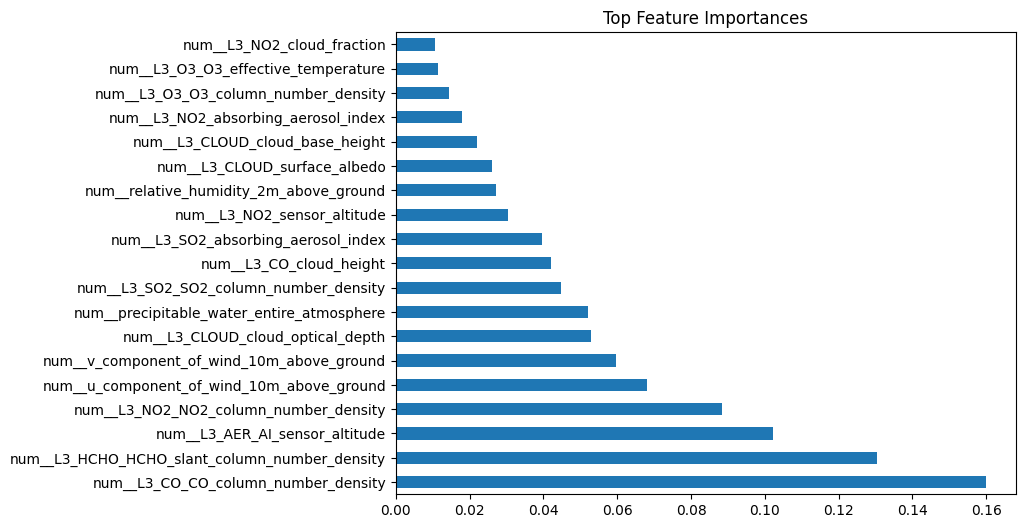

0.80041885

In [ ]:
# plot feature importance (for tree models only)
rf = model.named_steps['model']
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

importances = pd.Series(rf.feature_importances_, index=feature_names)
importances.nlargest(30).plot(kind='barh', figsize=(8,6))
plt.title("Top Feature Importances")
plt.show()

# top 5 RF:
# skewed__L3_CO_CO_column_number_density              0.143631
# skewed__L3_NO2_NO2_column_number_density            0.089796
# skewed__L3_AER_AI_sensor_altitude                   0.086519
# normal__L3_HCHO_HCHO_slant_column_number_density    0.078402
# skewed__L3_NO2_sensor_altitude                      0.069834
importances.nlargest(10).sum()


In [ ]:
# how-to visualize post/in-pipe to see prep changes?